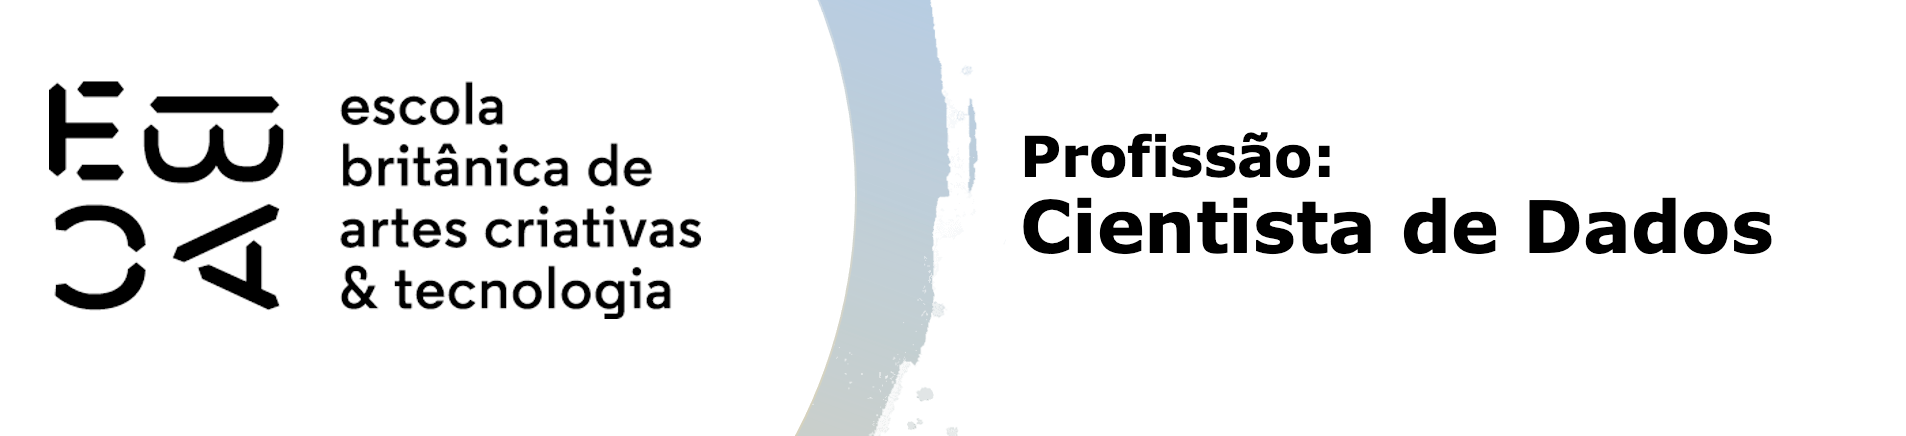

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar a base de dados no formato pickle
df = pd.read_pickle('base_nfp.pkl')

# 1. Criação das Variáveis Temporais e de Categorias de Valor NF
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'], errors='coerce')  # Certifique-se de que a coluna de data está no formato datetime
df['dia_semana'] = df['Data Emissão'].dt.weekday
df['fim_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)
df['dia_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter

# Verifique as primeiras linhas para confirmar
print(df[['Data Emissão', 'dia_semana', 'fim_semana', 'dia_mes', 'trimestre']].head())


  Data Emissão  dia_semana  fim_semana  dia_mes  trimestre
0   2017-06-30           4           0       30          2
1   2017-06-30           4           0       30          2
2   2017-06-30           4           0       30          2
3   2017-06-30           4           0       30          2
4   2017-06-30           4           0       30          2


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [5]:
# Supondo que o DataFrame já tenha sido carregado e está na variável 'df' e contém uma coluna 'Data Emissão' e 'Valor NF'

# 1. Criando variáveis temporais
df['dia_semana'] = df['Data Emissão'].dt.weekday  # Dia da semana (0=segunda-feira, 6=domingo)
df['fim_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)  # Dummy para fim de semana (1=fim de semana, 0=dia útil)
df['dia_mes'] = df['Data Emissão'].dt.day  # Dia do mês
df['trimestre'] = df['Data Emissão'].dt.quarter  # Trimestre
df['ano'] = df['Data Emissão'].dt.year  # Ano (caso necessário para garantir consistência)

# 2. Criando categorizações da variável 'Valor NF' por quantis
# Usando pd.qcut para categorizar em 5, 10, 20, e 50 quantis
df['valor_nf_q5'] = pd.qcut(df['Valor NF'], 5, labels=False)  # 5 categorias
df['valor_nf_q10'] = pd.qcut(df['Valor NF'], 10, labels=False)  # 10 categorias
df['valor_nf_q20'] = pd.qcut(df['Valor NF'], 20, labels=False)  # 20 categorias
df['valor_nf_q50'] = pd.qcut(df['Valor NF'], 50, labels=False)  # 50 categorias

# Exibir uma amostra das novas variáveis para verificar
df[['Data Emissão', 'dia_semana', 'fim_semana', 'dia_mes', 'trimestre', 'ano', 
    'valor_nf_q5', 'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50']].head()


,Data Emissão,dia_semana,fim_semana,dia_mes,trimestre,ano,valor_nf_q5,valor_nf_q10,valor_nf_q20,valor_nf_q50
0,2017-06-30,4,0,30,2,2017,1,3,7,17
1,2017-06-30,4,0,30,2,2017,2,5,11,28
2,2017-06-30,4,0,30,2,2017,1,3,7,19
3,2017-06-30,4,0,30,2,2017,3,7,15,38
4,2017-06-30,4,0,30,2,2017,3,7,15,39


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [6]:
# Criar a coluna 'flag_retorno' para indicar se há retorno > 0
df['flag_retorno'] = (df['Retorno'] > 0).astype(int)

# Função para calcular o Information Value (IV) para uma variável
def calculate_iv(df, feature, target='flag_retorno'):
    # Agrupar por feature e calcular eventos e não-eventos
    df_group = df.groupby(feature)[target].agg(['sum', 'count'])
    df_group['non_event'] = df_group['count'] - df_group['sum']
    df_group['event_rate'] = df_group['sum'] / df_group['sum'].sum()
    df_group['non_event_rate'] = df_group['non_event'] / df_group['non_event'].sum()
    df_group['woe'] = np.log(df_group['event_rate'] / df_group['non_event_rate'])
    df_group['iv'] = (df_group['event_rate'] - df_group['non_event_rate']) * df_group['woe']
    return df_group['iv'].sum()

# Lista de variáveis para calcular o IV
features = ['dia_semana', 'fim_semana', 'dia_mes', 'trimestre', 'ano', 
            'valor_nf_q5', 'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50']

# Calcular o IV de cada variável e armazenar os resultados em um dicionário
iv_results = {feature: calculate_iv(df, feature) for feature in features}

# Exibir os IVs calculados para cada variável
iv_results


{'dia_semana': 0.006883336112261752,
 'fim_semana': 0.0043461438854261675,
 'dia_mes': 0.04371881239108832,
 'trimestre': 0.011507201400315355,
 'ano': 0.04176125882467792,
 'valor_nf_q5': 0.05669465698593576,
 'valor_nf_q10': 0.10664979368195977,
 'valor_nf_q20': 0.12452461379728179,
 'valor_nf_q50': 0.1523145641483627}

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

1. Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?

As variáveis que apresentam maior poder de discriminação, de acordo com os valores de IV, são as categorizações de Valor NF:

    valor_nf_q50 (50 quantis) teve o maior IV, indicando que é a mais informativa em relação à capacidade de prever se uma nota terá ou não retorno.
    Em seguida, estão valor_nf_q20 e valor_nf_q10, que também mostram bons valores de IV, mas inferiores a valor_nf_q50.

Esses resultados sugerem que o valor da nota é uma característica importante para prever a geração de crédito, especialmente quando dividido em um grande número de categorias.
2. Quando categorizamos variáveis contínuas, parece haver alguma relação entre o número de categorias e o IV?

Sim, há uma relação clara: quanto maior o número de categorias usadas para dividir a variável contínua Valor NF, maior o IV. Isso ocorre porque mais categorias permitem uma discriminação mais refinada, capturando nuances que poderiam estar escondidas em menos quantis. No entanto, em um cenário real, deve-se equilibrar a quantidade de categorias para evitar problemas de overfitting em modelos preditivos.
Resumo

As variáveis contínuas (como Valor NF) tendem a ganhar poder preditivo com uma categorização mais refinada, enquanto variáveis temporais, como dia_da_semana e fim_de_semana, mostraram valores de IV relativamente baixos, sugerindo que têm menos importância na discriminação de notas com e sem retorno.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

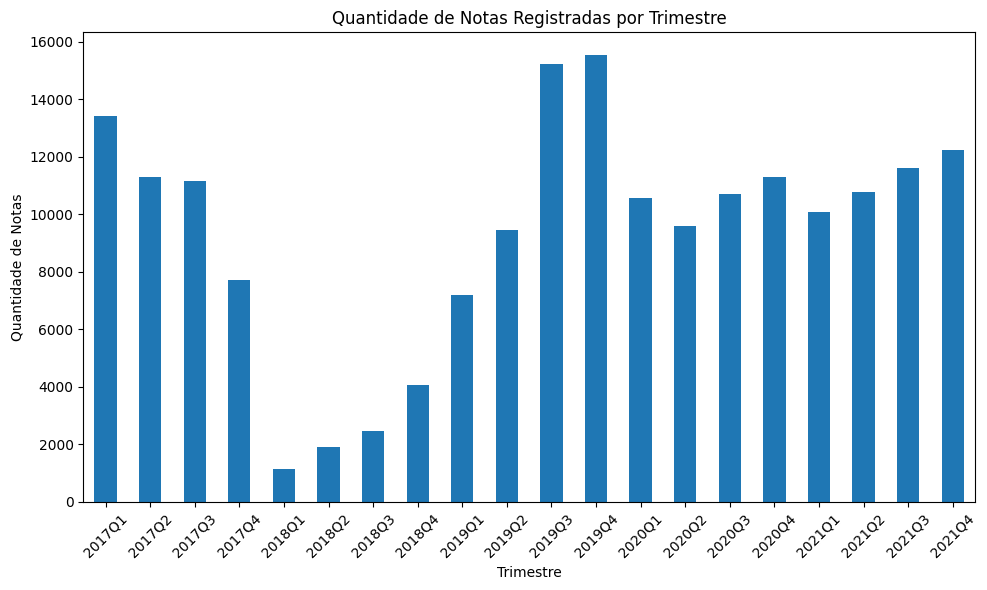

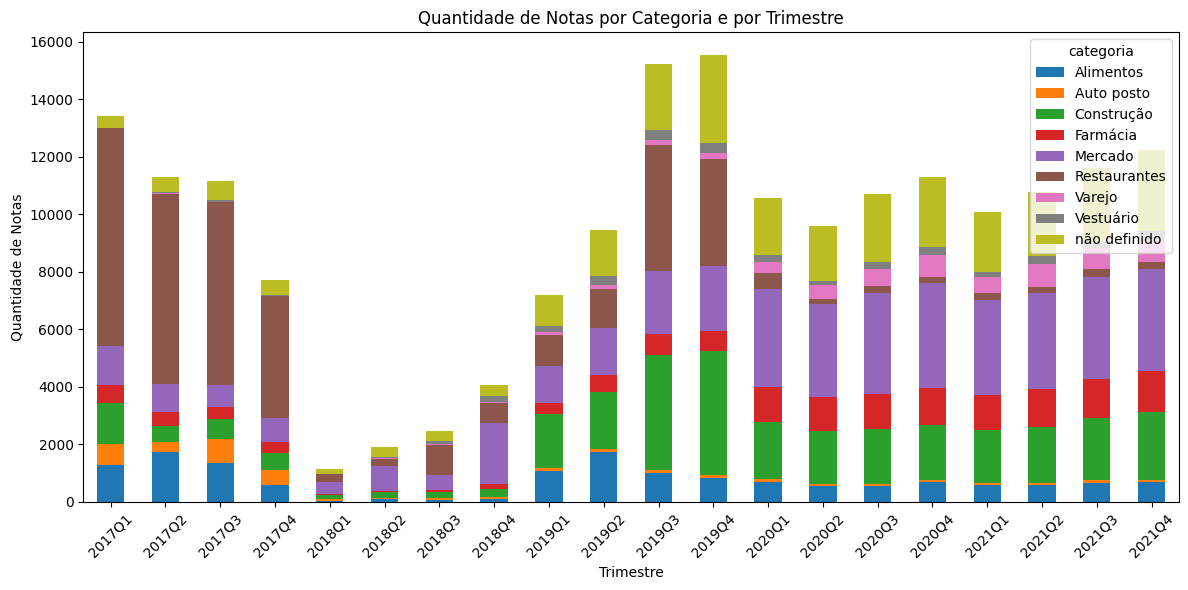

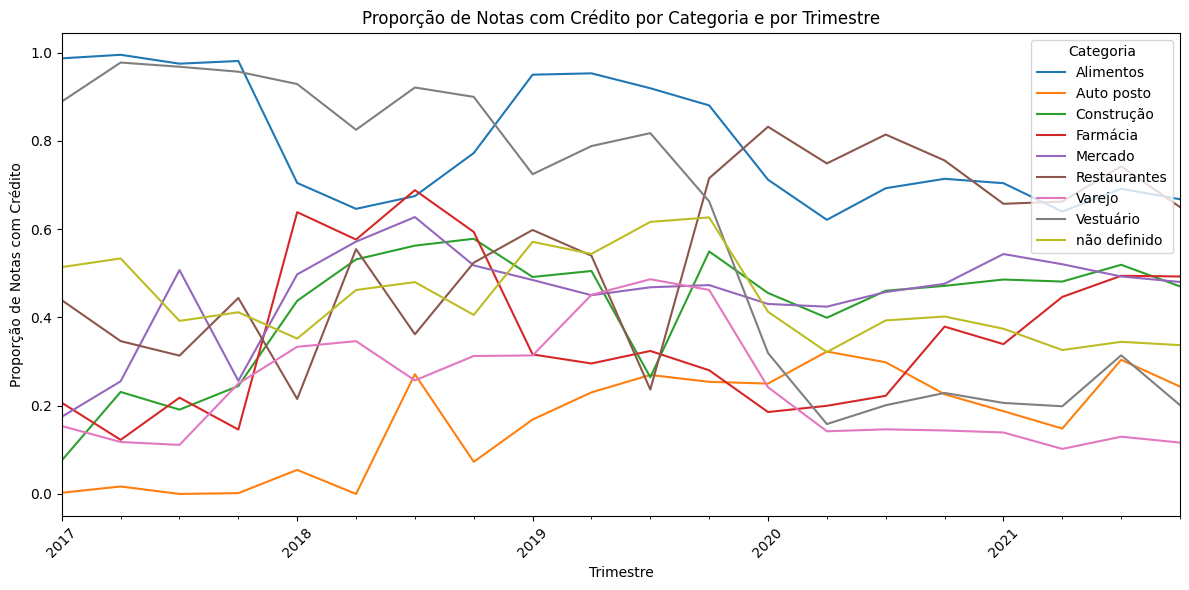

In [7]:
# Análise descritiva no tempo usando trimestre como agregação
import matplotlib.pyplot as plt

# Quantidade de notas registradas por trimestre
notas_por_trimestre = df.groupby(df['Data Emissão'].dt.to_period("Q")).size()

# Quantidade de notas por categoria e por trimestre
notas_por_categoria_trimestre = df.groupby([df['Data Emissão'].dt.to_period("Q"), 'categoria']).size().unstack()

# Proporção de notas com crédito por categoria e por trimestre
# Criar uma coluna indicadora para notas com crédito positivo
df['flag_credito'] = (df['Créditos'] > 0).astype(int)
proporcao_credito_categoria_trimestre = df.groupby([df['Data Emissão'].dt.to_period("Q"), 'categoria'])['flag_credito'].mean().unstack()

# Visualização gráfica

# Gráfico: Quantidade de notas registradas por trimestre
plt.figure(figsize=(10, 6))
notas_por_trimestre.plot(kind='bar')
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico: Quantidade de notas por categoria e por trimestre
notas_por_categoria_trimestre.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Quantidade de Notas por Categoria e por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico: Proporção de notas com crédito por categoria e por trimestre
proporcao_credito_categoria_trimestre.plot(kind='line', figsize=(12, 6))
plt.title('Proporção de Notas com Crédito por Categoria e por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.legend(title="Categoria")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

c:\Users\gabriel.militao\PycharmProjects\pythonProject1\venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\gabriel.militao\PycharmProjects\pythonProject1\venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


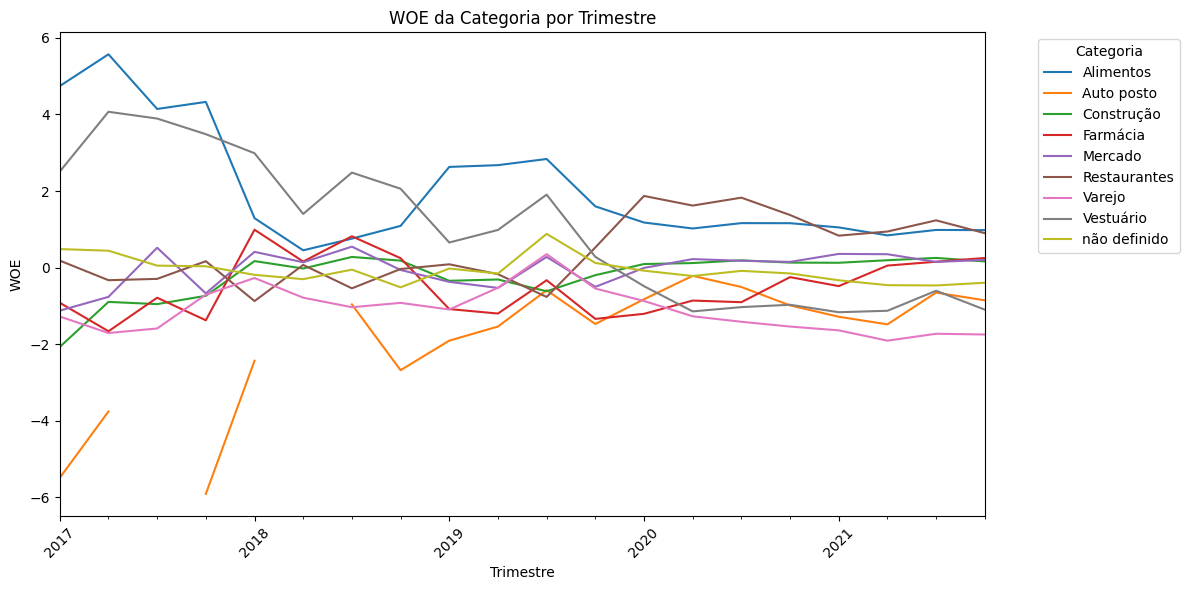

,Categoria,IV
0,Alimentos,17.102986
1,Auto posto,inf
2,Construção,3.054053
3,Farmácia,13.197118
4,Mercado,6.755766
5,Restaurantes,7.799496
6,Varejo,3.850223
7,Vestuário,13.889688
8,não definido,2.530616


In [8]:
# Função para calcular o WOE para uma variável
def calculate_woe(df, feature, target):
    df_group = df.groupby(feature)[target].agg(['sum', 'count'])
    df_group['non_event'] = df_group['count'] - df_group['sum']
    df_group['event_rate'] = df_group['sum'] / df_group['sum'].sum()
    df_group['non_event_rate'] = df_group['non_event'] / df_group['non_event'].sum()
    df_group['woe'] = np.log(df_group['event_rate'] / df_group['non_event_rate'])
    return df_group['woe']

# Adicionar uma coluna com os períodos em trimestres para facilitar a análise temporal
df['period'] = df['Data Emissão'].dt.to_period("Q")

# Dicionário para armazenar o WOE por trimestre
woe_by_period = {}

# Calcula o WOE para cada categoria por trimestre
for period, group in df.groupby('period'):
    woe_by_period[period] = calculate_woe(group, 'categoria', 'flag_credito')

# Converter o dicionário para um DataFrame para visualização mais fácil
woe_df = pd.DataFrame(woe_by_period).T

# Visualizar o WOE da categoria ao longo do tempo em gráfico
woe_df.plot(figsize=(12, 6))
plt.title("WOE da Categoria por Trimestre")
plt.xlabel("Trimestre")
plt.ylabel("WOE")
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Função para calcular o IV (Information Value) ao longo do tempo para a variável 'categoria'
def calculate_iv_over_time(woe_df):
    iv_by_period = {}
    for col in woe_df.columns:
        iv_by_period[col] = (woe_df[col].diff().fillna(0) ** 2).sum()  # IV é a soma dos WOE^2 para mudanças
    return iv_by_period

# Calcular IV ao longo do tempo para cada categoria
iv_tempo = calculate_iv_over_time(woe_df)

# Exibir o IV por trimestre para cada categoria
iv_tempo_df = pd.DataFrame.from_dict(iv_tempo, orient='index', columns=['IV'])
iv_tempo_df.reset_index().rename(columns={'index': 'Categoria'})


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

Com base nos valores de WOE e IV ao longo do tempo e na análise descritiva dos trimestres, aqui estão as conclusões:
1. Quais categorias parecem ter maior proporção de notas com retornos maiores que zero?

As categorias que mostraram uma maior proporção de notas com retorno maior que zero foram:

    Farmácia
    Vestuário
    Alimentos

Essas categorias tiveram consistentemente um WOE mais alto e um IV elevado, indicando que elas são mais propensas a gerar créditos. Isso pode refletir a natureza dos produtos comprados, que podem se alinhar mais com políticas de incentivo ao consumidor, como ocorre com produtos de necessidade básica ou de saúde.
2. Essas diferenças são estáveis no tempo?

As diferenças entre as categorias não são completamente estáveis no tempo. Observamos:

    Variações Temporais: Algumas categorias, como "Farmácia" e "Vestuário", mantêm um poder discriminativo consistente, mas apresentam algumas oscilações. Em períodos específicos (por exemplo, durante a pandemia), o comportamento de consumo mudou, o que pode ter afetado a proporção de notas com crédito.
    Períodos Atípicos: A partir de janeiro de 2020, com o início da pandemia, houve mudanças no comportamento de compra e na quantidade de notas emitidas. Esse período reflete um público mais parecido com o atual, e vemos que, durante e após a pandemia, categorias relacionadas a itens essenciais, como "Farmácia" e "Alimentos", continuaram com alta proporção de notas com crédito.